In [1]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

using gpu 1


In [2]:
#Checking wich GPU is beeing used

!nvidia-smi

Fri Nov  5 17:32:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   26C    P8    18W / 250W |   2287MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   

In [6]:
#Load data

#train and test data directory
data_dir = 'dialogue/Dataset/VoiceDetection/images/images_splitfolders/'
#data_dir = 'dialogue/Bjärn/images/splitfolders/'
#data_dir = 'dialogue/Olaf/images/mfcc/splitfolders/'

#load the train and test data
train_dataset = ImageFolder(data_dir + 'train',transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(data_dir + 'test',transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

#train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)#train_set is made into a dataloader, shuffled
#test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

print(len(train_dataset))
print(len(test_dataset))
print(len(test_dataset)/len(test_dataset+train_dataset))

1840
230
0.1111111111111111


In [7]:
img, label = train_dataset[0]
print(img.shape,label)
print("Follwing classes are there : \n",train_dataset.classes)

torch.Size([3, 150, 150]) 0
Follwing classes are there : 
 ['False', 'True']


Label : False


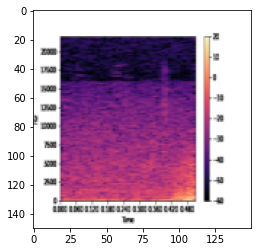

In [8]:

def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*train_dataset[0])

In [9]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128
val_size = 2000
train_size = len(train_dataset) - val_size 

train_data,val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_dataset)}")
print(f"Length of Test Data : {len(test_dataset)}")

#load the train and validation into batches.
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 1840
Length of Test Data : 230


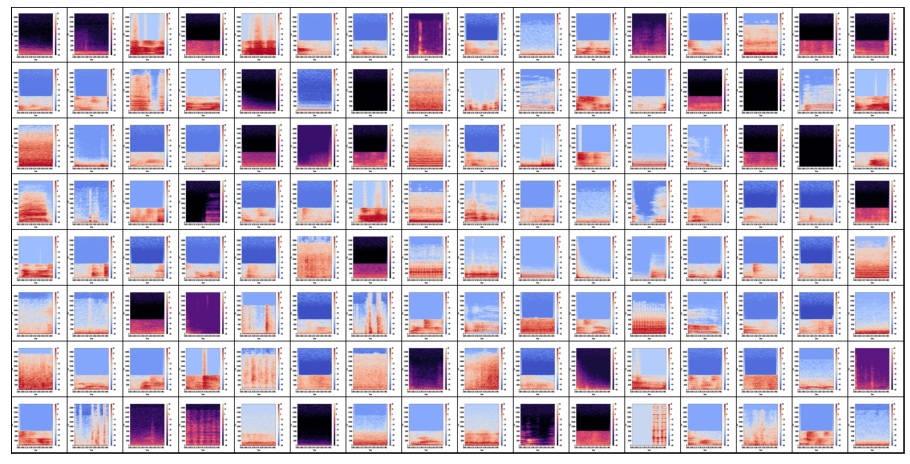

In [10]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [11]:
plt.close()

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [14]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [16]:
model = NaturalSceneClassification()
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)


NaturalSceneClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Li

In [17]:
model = to_device(NaturalSceneClassification(),device)
#evaluate(model,val_dl)
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.6839, val_loss: 0.7152, val_acc: 0.4000
Epoch [1], train_loss: 0.6957, val_loss: 0.7071, val_acc: 0.4000
Epoch [2], train_loss: 0.7014, val_loss: 0.6655, val_acc: 0.7188
Epoch [3], train_loss: 0.5968, val_loss: 0.6354, val_acc: 0.6250
Epoch [4], train_loss: 0.4496, val_loss: 0.3761, val_acc: 0.8562
Epoch [5], train_loss: 0.3258, val_loss: 0.2799, val_acc: 0.8875
Epoch [6], train_loss: 0.2484, val_loss: 0.3570, val_acc: 0.8938
Epoch [7], train_loss: 0.2694, val_loss: 0.2817, val_acc: 0.9000
Epoch [8], train_loss: 0.2481, val_loss: 0.2671, val_acc: 0.9000
Epoch [9], train_loss: 0.3125, val_loss: 0.2883, val_acc: 0.8875
Epoch [10], train_loss: 0.2469, val_loss: 0.2576, val_acc: 0.9000
Epoch [11], train_loss: 0.2220, val_loss: 0.2802, val_acc: 0.9000
Epoch [12], train_loss: 0.2317, val_loss: 0.2630, val_acc: 0.8938
Epoch [13], train_loss: 0.2533, val_loss: 0.2614, val_acc: 0.8938
Epoch [14], train_loss: 0.2298, val_loss: 0.2612, val_acc: 0.8938
Epoch [15], train_lo

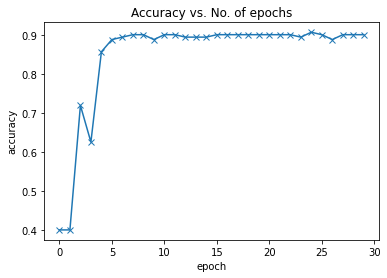

In [18]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

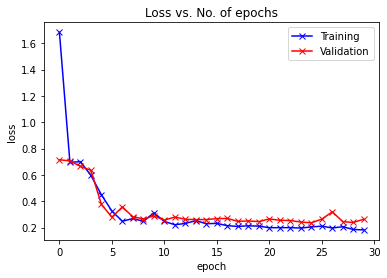

In [19]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [20]:
# Apply the model on test dataset and Get the results
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.13648395240306854, 'val_acc': 0.9434782862663269}

In [21]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = to_device(img.unsqueeze(0), device)
    print(type(img))
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return train_dataset.classes[preds[0].item()]

<class 'PIL.Image.Image'>
<PIL.Image.Image image mode=RGB size=432x288 at 0x7F2B844FC580>
<class 'torch.Tensor'>


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x497664 and 82944x1024)

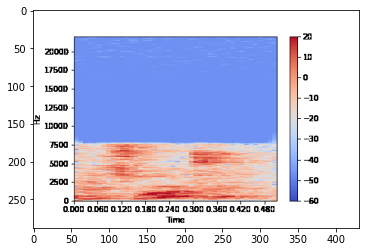

In [22]:
from PIL import Image

#open image file
img = Image.open("dialogue/Dataset/VoiceDetection/images/images_splitfolders/val/True/1113_True_dataset_with_negatives_spectro.png")

img = img.convert('RGB')
print(type(img))
print(img)
#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model)}")

In [ ]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
